In [3]:
from qiskit import *
from qiskit.providers.aer import AerSimulator
from qiskit.circuit import QuantumCircuit

# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

from typing import Optional

import numpy as np
from random import *

In [4]:
def create_circuit(state: str, delay: int, basis: Optional[dict] = {0: 'z'}, plus_minus: Optional[dict] = {0: 'z'}) -> QuantumCircuit:
    """For BB84, we take state to be '0', '1', '+', '-' """
    """basis will be of the form -> {0: 'x', 1: 'z'}, i.e., the qubit number followed
    by the basis of measurement"""
    
    qc = QuantumCircuit(1)
    
    # create the appropriate start state
    if state[0] == '1':
        qc.x(0)
    if state[0] == '+':
        qc.h(0)
    if state[0] == '-':
        qc.x(0)
        qc.h(0)
    
    # apply the delay
    qc.delay(delay, unit='ns')
    
    # apply the appropriate basis rotation
    for qubit, rot in basis.items():
        if qubit > 1:
            raise ValueError('Provided qubit number exceeds the number of qubits in the circuit')
        else:
            if rot == 'x' or rot == 'X':
                qc.h(qubit)
            elif rot == 'y' or rot == 'Y':
                qc.sdg(qubit)
                qc.h(qubit)
                
    # apply the Hadamard to obtain + and - state
    for gate, hadamard in plus_minus.items():
        if gate > 1:
            raise ValueError('Provided H Gate number exceeds in the circuit for + or - State')
        else:
            if hadamard == 'h' or hadamard == 'H':
                qc.h(qubit)
    
    # final measurement
    qc.measure_all()
    
    return qc

In [5]:
print(create_circuit('1',100))

        ┌───┐┌────────────────┐ ░ ┌─┐
     q: ┤ X ├┤ Delay(100[ns]) ├─░─┤M├
        └───┘└────────────────┘ ░ └╥┘
meas: 1/═══════════════════════════╩═
                                   0 


In [6]:
print(create_circuit('-',100,{0: 'z'},{0: 'h'}))

        ┌───┐┌───┐┌────────────────┐┌───┐ ░ ┌─┐
     q: ┤ X ├┤ H ├┤ Delay(100[ns]) ├┤ H ├─░─┤M├
        └───┘└───┘└────────────────┘└───┘ ░ └╥┘
meas: 1/═════════════════════════════════════╩═
                                             0 


In [7]:
def make_noise(noise_params: dict, delay: int, q1_gate_len: int,
               q2_gate_len: int, measure_len: int, apply_error: dict) -> NoiseModel:
    """noise params contains the values of T1, T2"""
    """1q_gate_len, 2q_gate_len, measure_len gives the duration of each"""
    """apply_error -> {"delay": bool, "measure": bool, "gate": bool} -> states which errors are on"""
    
    noise_model = NoiseModel()
    
    if apply_error["delay"]:
        thermal_delay = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],delay)
        noise_model.add_all_qubit_quantum_error(thermal_delay,"delay")
        
    if apply_error["measure"]:
        thermal_measure = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],measure_len)
        noise_model.add_all_qubit_quantum_error(thermal_measure,"measure")
    
    if apply_error["gate"]:
        thermal_gate_1q = thermal_relaxation_error(noise_params["T1"],noise_params["T2"],q1_gate_len)
        noise_model.add_all_qubit_quantum_error(thermal_gate_1q,["x","h","id"])
        
    
    return noise_model

In [8]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": True})

<NoiseModel on ['delay', 'measure', 'id', 'x', 'h']>

In [9]:
make_noise({"T1":188000, "T2":190000}, 100, 1000, 3000, 5000,
          {"delay":True, "measure": True, "gate": False})

<NoiseModel on ['delay', 'measure']>

In [10]:
noise_params = {"T1":193020, "T2":257470} # ibmq_armonk T1: 193.02 , T2:257.47 us
q1_gate_len = 200 # couldn't find
q2_gate_len = 405.33 # ibmq_armonk   x: 2.280e-4 
measure_len = 4977.778 # ibmq_armonk  4977.778 

In [11]:
def run(channel: str, delay: int, apply_error: dict, shots: Optional[int] = 1000) -> float:
    """Returns the probability of success for BB84 protocol"""
    """Channel: 1 => |0>+|1>, 2 => |0>+|1> 3 =>|0>+|1>  4=>|0>+|1> """
    
    if channel == '1':
        state = '0'
    elif channel == '2':
        state = '1'
    elif channel == '3':
        state = '+'
    elif channel == '4':
        state = '-'  
    
    qc = create_circuit(state,delay)
    backend = AerSimulator(noise_model=make_noise(noise_params,delay,q1_gate_len,q2_gate_len,measure_len,apply_error))
    counts = backend.run(qc,shots=shots).result().get_counts()
    #print(counts)
    success = 0
    
    if channel == '1':
        if '0' in counts.keys():
            success += counts['0']
        else:
            success +=0
#         if '1' in counts.keys():
#             success += counts['1']
    elif channel == '2':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']
        else:
            success +=0
    elif channel == '3':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
    elif channel == '4':
        #if '0' in counts.keys():
            #success += counts['0']
        if '1' in counts.keys():
            success += counts['1']+500
        else:
            success +=500
            
    
    return float(success/shots)

In [12]:
run('2',1000,{"delay": True, "measure": True, "gate": True})

0.965

In [13]:
run('1',1000,{"delay": True, "measure": True, "gate": True})

1.0

In [14]:
run('3',1000,{"delay": True, "measure": True, "gate": True})

0.993

In [15]:
run('4',1000,{"delay": True, "measure": True, "gate": True})

0.974

# Total Probability of Success Graph

# Delay 

In [36]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist=[]
for i in range(len(state_list)):
    delay = np.arange(0,1001000,1000)
    channel = state_list[i]
    apply_error = {"delay":True, "measure": False, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    totalplist.append(success)

In [37]:
from statistics import mean
a= totalplist
print(*map(mean, zip(*a)))

0.9997499999999999 0.9995 1.003 0.9904999999999999 0.983 0.989 0.97725 0.97575 0.97225 0.9834999999999999 0.9682499999999999 0.9672499999999999 0.9742500000000001 0.9575 0.96675 0.95875 0.9490000000000001 0.947 0.956 0.9525 0.95075 0.945 0.9445 0.948 0.947 0.94675 0.94475 0.93575 0.92675 0.93275 0.93 0.9237500000000001 0.917 0.93125 0.922 0.929 0.93175 0.91475 0.906 0.911 0.91075 0.89375 0.9105 0.8965000000000001 0.895 0.886 0.8925000000000001 0.89575 0.899 0.895 0.885 0.8775 0.88175 0.87625 0.88225 0.87975 0.877 0.8725 0.86575 0.8525 0.8665 0.85625 0.861 0.85825 0.86525 0.85175 0.868 0.85225 0.8545 0.84375 0.8492500000000001 0.8372499999999999 0.8485 0.8345 0.8365 0.846 0.84325 0.8305 0.8275 0.82025 0.8262499999999999 0.832 0.8362499999999999 0.83875 0.819 0.81825 0.83175 0.82675 0.82125 0.8065 0.80575 0.8235 0.80575 0.812 0.7987500000000001 0.80825 0.79775 0.79225 0.80775 0.8029999999999999 0.7975 0.7995 0.8015 0.79375 0.778 0.80025 0.795 0.77875 0.78825 0.77825 0.784 0.7857500000000

In [38]:
Success=[0.9997499999999999,0.9995,1.003,0.9904999999999999,0.983,0.989,0.97725,0.97575,0.97225,0.9834999999999999,0.9682499999999999,0.9672499999999999,0.9742500000000001,0.9575,0.96675,0.95875,0.9490000000000001,0.947,0.956,0.9525,0.95075,0.945,0.9445,0.948,0.947,0.94675,0.94475,0.93575,0.92675,0.93275,0.93,0.9237500000000001,0.917,0.93125,0.922,0.929,0.93175,0.91475,0.906,0.911,0.91075,0.89375,0.9105,0.8965000000000001,0.895,0.886,0.8925000000000001,0.89575,0.899,0.895,0.885,0.8775,0.88175,0.87625,0.88225,0.87975,0.877,0.8725,0.86575,0.8525,0.8665,0.85625,0.861,0.85825,0.86525,0.85175,0.868,0.85225,0.8545,0.84375,0.8492500000000001,0.8372499999999999,0.8485,0.8345,0.8365,0.846,0.84325,0.8305,0.8275,0.82025,0.8262499999999999,0.832,0.8362499999999999,0.83875,0.819,0.81825,0.83175,0.82675,0.82125,0.8065,0.80575,0.8235,0.80575,0.812,0.7987500000000001,0.80825,0.79775,0.79225,0.80775,0.8029999999999999,0.7975,0.7995,0.8015,0.79375,0.778,0.80025,0.795,0.77875,0.78825,0.77825,0.784,0.7857500000000001,0.772,0.782,0.787,0.76675,0.7775000000000001,0.77175,0.76875,0.766,0.7645,0.7785,0.76125,0.76425,0.762,0.759,0.76075,0.747,0.758,0.74825,0.75225,0.762,0.73775,0.75025,0.7444999999999999,0.74875,0.7495,0.7515000000000001,0.7585,0.7435,0.73875,0.744,0.7435,0.74275,0.7415,0.73675,0.73075,0.73125,0.74075,0.7225,0.732,0.722,0.7305,0.7364999999999999,0.73025,0.73,0.72375,0.727,0.72,0.72175,0.71675,0.72025,0.7135,0.7132499999999999,0.712,0.7155,0.705,0.70475,0.707,0.7055,0.69475,0.7075,0.71,0.697,0.69875,0.71075,0.70675,0.702,0.6970000000000001,0.694,0.7005,0.697,0.68875,0.6955,0.68975,0.69775,0.6912499999999999,0.6795,0.6855,0.677,0.69675,0.68125,0.68825,0.68725,0.6795,0.6805,0.6775,0.6817500000000001,0.6865,0.67125,0.68375,0.68575,0.6727500000000001,0.67425,0.66875,0.67325,0.668,0.67275,0.67425,0.6625,0.67025,0.6745,0.6737500000000001,0.6785,0.673,0.6675,0.67875,0.657,0.6645,0.657,0.6575,0.6637500000000001,0.6567500000000001,0.66825,0.6647500000000001,0.6575,0.6647500000000001,0.67025,0.6605,0.657,0.6567500000000001,0.6455,0.65225,0.646,0.65575,0.6505,0.648,0.6515,0.6475,0.64525,0.6485,0.637,0.64425,0.6395,0.6455,0.6405,0.644,0.632,0.6355,0.64475,0.63825,0.64025,0.64,0.635,0.629,0.6305,0.634,0.63525,0.6285000000000001,0.63075,0.6275,0.62725,0.629,0.62675,0.633,0.62775,0.6275,0.63225,0.626,0.611,0.62125,0.6265000000000001,0.62075,0.62575,0.623,0.6295,0.62925,0.61525,0.61325,0.61425,0.61875,0.6225,0.62375,0.61525,0.6165,0.61125,0.608,0.61125,0.61425,0.60825,0.61475,0.614,0.6095,0.61175,0.60875,0.60875,0.60575,0.60775,0.60775,0.601,0.60175,0.604,0.60775,0.6035,0.60325,0.604,0.61025,0.59625,0.60525,0.59075,0.5995,0.6015,0.59975,0.60175,0.59375,0.598,0.58675,0.5925,0.59875,0.60375,0.59525,0.5965,0.59975,0.5862499999999999,0.59725,0.585,0.596,0.5832499999999999,0.5912499999999999,0.5922499999999999,0.593,0.5905,0.5852499999999999,0.597,0.5845,0.5882499999999999,0.597,0.58375,0.5775,0.584,0.5822499999999999,0.581,0.58775,0.5812499999999999,0.586,0.5835,0.5762499999999999,0.5872499999999999,0.593,0.5762499999999999,0.5785,0.5742499999999999,0.582,0.5772499999999999,0.5785,0.5785,0.577,0.5752499999999999,0.57875,0.578,0.57275,0.57175,0.58675,0.5832499999999999,0.5702499999999999,0.57375,0.5752499999999999,0.574,0.5722499999999999,0.576,0.5772499999999999,0.5725,0.5702499999999999,0.57075,0.5722499999999999,0.5715,0.5702499999999999,0.577,0.57025,0.5755,0.5645,0.57675,0.56325,0.5742499999999999,0.571,0.56825,0.567,0.56875,0.567,0.57,0.56225,0.56575,0.5625,0.5735,0.56825,0.5685,0.5635,0.5655,0.5665,0.5645,0.56075,0.55975,0.55475,0.555,0.558,0.5685,0.5577500000000001,0.5615,0.5567500000000001,0.56225,0.557,0.55725,0.5585,0.55775,0.5635,0.55775,0.556,0.559,0.55925,0.56125,0.553,0.55225,0.55425,0.55925,0.5517500000000001,0.548,0.5625,0.5475,0.5477500000000001,0.556,0.5535,0.5555,0.5547500000000001,0.5555,0.5517500000000001,0.55475,0.551,0.55,0.558,0.549,0.54925,0.54725,0.554,0.5507500000000001,0.5537500000000001,0.5555,0.5475,0.5535,0.5505,0.5445,0.5497500000000001,0.551,0.547,0.545,0.55725,0.5497500000000001,0.5485,0.551,0.5475,0.546,0.54325,0.541,0.5477500000000001,0.5417500000000001,0.54,0.545,0.55025,0.54975,0.5437500000000001,0.5395,0.5485,0.543,0.54025,0.5435,0.53725,0.54325,0.5435,0.539,0.5437500000000001,0.5457500000000001,0.5357500000000001,0.538,0.53825,0.5385,0.549,0.541,0.539,0.539,0.541,0.53925,0.5395,0.5385,0.53325,0.54025,0.5357500000000001,0.54,0.533,0.53725,0.5407500000000001,0.5385,0.5377500000000001,0.5395,0.5367500000000001,0.53425,0.53825,0.5375,0.53525,0.5347500000000001,0.5377500000000001,0.5305,0.5327500000000001,0.5305,0.539,0.53025,0.535,0.53225,0.5365,0.537,0.5305,0.52925,0.53325,0.5335,0.53625,0.533,0.5345,0.53825,0.531,0.53125,0.52875,0.532,0.529,0.53625,0.53825,0.527,0.52925,0.531,0.52625,0.527,0.52525,0.529,0.532,0.53125,0.528,0.5285,0.52475,0.532,0.5295,0.53425,0.52925,0.534,0.52775,0.52925,0.52325,0.52925,0.52775,0.52925,0.531,0.52825,0.52775,0.53025,0.52375,0.5317500000000001,0.5305,0.5295,0.5255,0.52775,0.528,0.52425,0.5245,0.533,0.52575,0.529,0.525,0.52425,0.527,0.526,0.51925,0.52925,0.5235,0.527,0.527,0.521,0.521,0.5245,0.52875,0.5245,0.5255,0.525,0.529,0.5215,0.5265,0.52475,0.52275,0.5235,0.5215,0.523,0.5185,0.51725,0.523,0.52375,0.5205,0.52025,0.5215,0.52225,0.523,0.521,0.523,0.521,0.52475,0.521,0.524,0.5175,0.52275,0.5255,0.52025,0.5185,0.52175,0.519,0.52125,0.519,0.51975,0.516,0.52325,0.522,0.523,0.5195,0.52025,0.518,0.518,0.52125,0.5205,0.51925,0.5235,0.51875,0.52225,0.51675,0.5175,0.517,0.517,0.52025,0.516,0.521,0.5205,0.519,0.51625,0.51925,0.52025,0.516,0.51725,0.526,0.51625,0.518,0.515,0.51775,0.51775,0.51425,0.51225,0.515,0.51575,0.513,0.51675,0.51625,0.5155,0.5135,0.51775,0.517,0.515,0.5165,0.51775,0.5155,0.51475,0.51275,0.516,0.5125,0.517,0.51525,0.517,0.51425,0.51475,0.512,0.5135,0.5145,0.51325,0.51475,0.51325,0.51325,0.51325,0.5135,0.51575,0.51275,0.51425,0.5115,0.51525,0.51175,0.51525,0.51375,0.513,0.51275,0.5135,0.50975,0.51325,0.51225,0.51075,0.518,0.51625,0.5155,0.514,0.514,0.513,0.5155,0.5075,0.51025,0.51525,0.5135,0.51425,0.51175,0.513,0.5115,0.512,0.5145,0.51,0.5095,0.5145,0.50925,0.50975,0.5145,0.51425,0.5145,0.514,0.5095,0.5115,0.511,0.50975,0.51075,0.5135,0.5115,0.51125,0.5115,0.51125,0.51,0.51,0.51125,0.5105,0.51125,0.5125,0.51,0.515,0.5075,0.511,0.5105,0.5105,0.50825,0.50925,0.51025,0.50975,0.509,0.50775,0.5115,0.50975,0.50875,0.512,0.50975,0.50625,0.5055,0.509,0.508,0.5085,0.509,0.5085,0.50775,0.509,0.5085,0.507,0.50725,0.5065,0.50875,0.508,0.50925,0.51025,0.50825,0.51275,0.50925,0.50675,0.508,0.5085,0.50925,0.5095,0.5105,0.50975,0.507,0.50675,0.5085,0.5065,0.51175,0.508,0.50725,0.5095,0.50925,0.50825,0.50675,0.51,0.50775,0.5095,0.50725,0.5075,0.50975,0.5075,0.51025,0.50775,0.5055,0.50825,0.50625,0.5085,0.50925,0.50575,0.507,0.505,0.5075,0.50825,0.5045,0.506,0.5075,0.511,0.50825,0.50525,0.50725,0.50825,0.50575,0.5075,0.505,0.5085,0.50525,0.50675,0.5075,0.50825,0.50575,0.50575,0.50625,0.50475,0.508,0.50475,0.50775,0.5055,0.5055,0.50725,0.50525,0.505,0.50575,0.50525,0.50725,0.50875,0.50475,0.50525,0.506,0.50525,0.506,0.50525,0.5065,0.50825,0.505,0.506,0.505,0.5055,0.50475,0.50625,0.50775,0.50325,0.50475,0.50625,0.5045,0.505,0.50625,0.50625,0.50475,0.5055,0.50675,0.505,0.50425,0.50325,0.5065,0.50375,0.50625,0.50525,0.505,0.507,0.50425,0.50675,0.50725,0.505,0.5055,0.5065,0.505,0.50625,0.50525,0.5045,0.5045,0.505,0.5035,0.50475,0.5035,0.50525,0.50475,0.50525,0.50625,0.50625,0.5055,0.5055,0.50525,0.506,0.50425,0.5055,0.5065,0.5045,0.5025,0.50575,0.5035,0.503,0.50575,0.50375,0.5035,0.50325,0.50375,0.50525,0.504,0.50325,0.50425,0.50325,0.5055,0.50375,0.5055,0.504,0.503,0.50325,0.50375,0.50275,0.504,0.50325,0.50375,0.5045,0.503,0.50425,0.504,0.5035,0.505,0.50325,0.50525,0.50375,0.50375,0.50425,0.50325,0.502,0.50325,0.50375,0.50375,0.504,0.5045,0.5045,0.50225,0.503,0.5025,0.504,0.502,0.503,0.50325,0.50475,0.50225,0.5035,0.5035,0.50275,0.50325,0.50325,0.504,0.50275,0.50225,0.504,0.50475,0.5025,0.50325,0.50375,0.504,0.50275,0.5055,0.50275,0.503,0.5035,0.50275,0.5025,0.5035,0.5025,0.50225,0.50225,0.5025,0.50275,0.504,0.50275,0.50375,0.5025,0.502,0.50225,0.5025,0.50325]

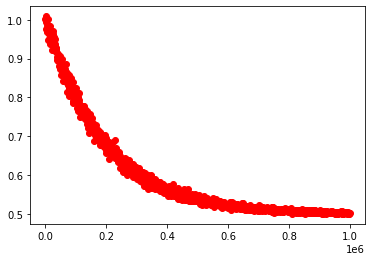

In [39]:
plt.plot(delay,success,'ro--')
plt.show()

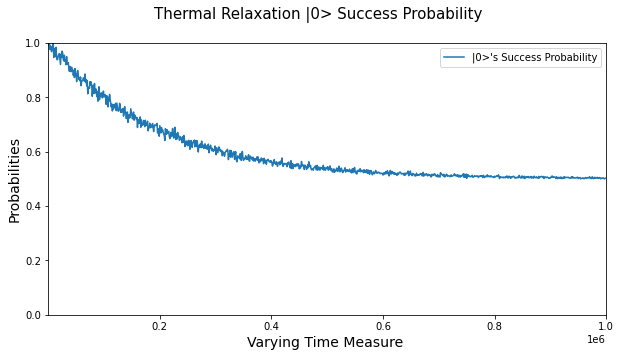

<Figure size 576x360 with 0 Axes>

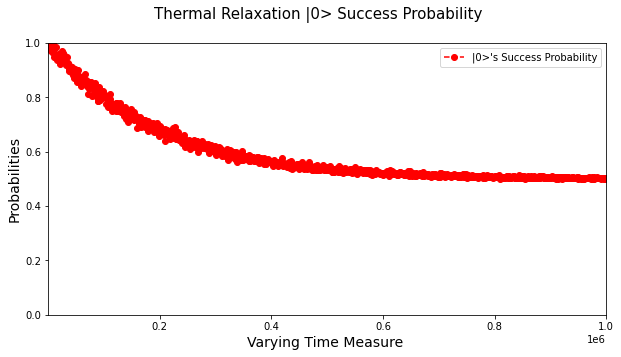

<Figure size 576x360 with 0 Axes>

In [40]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation BB84 Total Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "Total Success Prob: Delay")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation BB84 Total Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,'ro--',label = "Total Success Prob: Delay ")
ax.legend()

# Delay + Measure

In [41]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist1=[]
for i in range(len(state_list)):
    delay = np.arange(0,1001000,1000)
    channel = state_list[i]
    apply_error = {"delay":True, "measure": True, "gate": False}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    totalplist1.append(success)

In [42]:
from statistics import mean
a= totalplist1
print(*map(mean, zip(*a)))

0.99425 0.9884999999999999 0.98125 0.97675 0.979 0.97275 0.97275 0.97225 0.9655 0.962 0.9625 0.9515 0.94675 0.9545 0.9505 0.96175 0.94975 0.94225 0.94 0.9325 0.947 0.94825 0.9257500000000001 0.93425 0.924 0.9197500000000001 0.9395 0.92925 0.91875 0.9085 0.914 0.92425 0.908 0.91 0.9119999999999999 0.9077500000000001 0.89925 0.9065000000000001 0.90425 0.90575 0.903 0.88975 0.89425 0.88525 0.88825 0.8775 0.88675 0.87375 0.88025 0.875 0.887 0.871 0.87 0.85625 0.87025 0.86425 0.865 0.87025 0.852 0.86075 0.86475 0.85025 0.86525 0.8474999999999999 0.85 0.84175 0.841 0.8465 0.837 0.83375 0.827 0.8402499999999999 0.83175 0.83875 0.83175 0.8220000000000001 0.82525 0.8245 0.824 0.81275 0.82925 0.8205 0.812 0.8205 0.8067500000000001 0.81125 0.8242499999999999 0.8140000000000001 0.81475 0.802 0.798 0.7935 0.8005 0.8005 0.79875 0.8049999999999999 0.79925 0.7947500000000001 0.7975 0.7985 0.78425 0.7827500000000001 0.786 0.7847500000000001 0.79425 0.7855 0.78825 0.7795 0.772 0.77575 0.7715000000000001

In [43]:
success1 = [0.99425,0.9884999999999999,0.98125,0.97675,0.979,0.97275,0.97275,0.97225,0.9655,0.962,0.9625,0.9515,0.94675,0.9545,0.9505,0.96175,0.94975,0.94225,0.94,0.9325,0.947,0.94825,0.9257500000000001,0.93425,0.924,0.9197500000000001,0.9395,0.92925,0.91875,0.9085,0.914,0.92425,0.908,0.91,0.9119999999999999,0.9077500000000001,0.89925,0.9065000000000001,0.90425,0.90575,0.903,0.88975,0.89425,0.88525,0.88825,0.8775,0.88675,0.87375,0.88025,0.875,0.887,0.871,0.87,0.85625,0.87025,0.86425,0.865,0.87025,0.852,0.86075,0.86475,0.85025,0.86525,0.8474999999999999,0.85,0.84175,0.841,0.8465,0.837,0.83375,0.827,0.8402499999999999,0.83175,0.83875,0.83175,0.8220000000000001,0.82525,0.8245,0.824,0.81275,0.82925,0.8205,0.812,0.8205,0.8067500000000001,0.81125,0.8242499999999999,0.8140000000000001,0.81475,0.802,0.798,0.7935,0.8005,0.8005,0.79875,0.8049999999999999,0.79925,0.7947500000000001,0.7975,0.7985,0.78425,0.7827500000000001,0.786,0.7847500000000001,0.79425,0.7855,0.78825,0.7795,0.772,0.77575,0.7715000000000001,0.7845,0.77025,0.767,0.7705,0.766,0.76875,0.76725,0.7685,0.7605,0.766,0.7635000000000001,0.7645,0.75425,0.7595000000000001,0.75975,0.75175,0.743,0.75125,0.753,0.75475,0.755,0.7475,0.7415,0.746,0.74225,0.7355,0.7465,0.7315,0.7315,0.7345,0.74225,0.73725,0.74475,0.72675,0.7404999999999999,0.7345,0.72875,0.73575,0.72075,0.72125,0.71975,0.731,0.722,0.72025,0.722,0.72025,0.71675,0.7075,0.7125,0.72025,0.7125,0.7185,0.707,0.7155,0.70875,0.714,0.6992499999999999,0.706,0.69825,0.7095,0.69575,0.7055,0.6955,0.704,0.6965,0.69675,0.69275,0.69375,0.6875,0.67525,0.68825,0.6797500000000001,0.6945,0.68575,0.6985,0.6925,0.692,0.6757500000000001,0.67675,0.693,0.6717500000000001,0.6845,0.6779999999999999,0.6737500000000001,0.6797500000000001,0.67325,0.6697500000000001,0.68025,0.6705,0.67625,0.6687500000000001,0.677,0.673,0.6677500000000001,0.6697500000000001,0.67675,0.6757500000000001,0.666,0.6607500000000001,0.67475,0.6685,0.6677500000000001,0.657,0.6655,0.6665,0.655,0.6597500000000001,0.6585,0.6475,0.661,0.6595,0.65475,0.655,0.641,0.64375,0.64875,0.644,0.6395,0.6325000000000001,0.63775,0.6545,0.64975,0.645,0.64825,0.6415,0.6525,0.63675,0.64075,0.64175,0.6395,0.64775,0.643,0.645,0.6375,0.63875,0.63625,0.63325,0.6395,0.61925,0.62625,0.62925,0.63175,0.62825,0.637,0.62625,0.628,0.63175,0.63325,0.6335,0.6225,0.6225,0.61775,0.62675,0.6245,0.62075,0.62225,0.61675,0.6255,0.6214999999999999,0.6225,0.625,0.62425,0.6085,0.62625,0.6115,0.61475,0.6174999999999999,0.61475,0.616,0.619,0.6145,0.61525,0.614,0.6125,0.61525,0.62525,0.5975,0.615,0.60375,0.61675,0.60875,0.60775,0.61325,0.6075,0.616,0.609,0.59825,0.5995,0.59425,0.60275,0.60225,0.599,0.60425,0.60175,0.60225,0.592,0.5932499999999999,0.59525,0.59575,0.59725,0.59625,0.599,0.5925,0.59975,0.5862499999999999,0.59425,0.594,0.595,0.5925,0.6025,0.588,0.592,0.5902499999999999,0.5872499999999999,0.5895,0.5975,0.597,0.593,0.5875,0.5892499999999999,0.5875,0.5835,0.5912499999999999,0.5842499999999999,0.5925,0.58375,0.5825,0.5925,0.587,0.5795,0.581,0.5845,0.5882499999999999,0.5835,0.574,0.5785,0.5842499999999999,0.586,0.572,0.57425,0.574,0.579,0.576,0.57275,0.57675,0.574,0.5805,0.577,0.5762499999999999,0.5715,0.57375,0.57,0.5762499999999999,0.57125,0.578,0.5722499999999999,0.5722499999999999,0.56475,0.56675,0.5700000000000001,0.5745,0.5805,0.572,0.57,0.5782499999999999,0.568,0.57125,0.573,0.5635,0.57125,0.56575,0.5702499999999999,0.571,0.571,0.56725,0.56875,0.5682499999999999,0.56725,0.5655,0.56,0.5665,0.56725,0.5725,0.56675,0.56175,0.5640000000000001,0.56025,0.56225,0.56475,0.55725,0.5575,0.5615,0.5605,0.56025,0.55775,0.55975,0.55775,0.5555,0.55775,0.55625,0.5607500000000001,0.5567500000000001,0.56075,0.5537500000000001,0.5545,0.552,0.5575,0.551,0.556,0.55225,0.5585,0.55775,0.547,0.5547500000000001,0.555,0.553,0.556,0.5477500000000001,0.5497500000000001,0.5537500000000001,0.554,0.554,0.5587500000000001,0.55625,0.5495,0.5487500000000001,0.55,0.54525,0.5505,0.5517500000000001,0.5505,0.54625,0.548,0.55125,0.5447500000000001,0.54925,0.54425,0.5475,0.547,0.54825,0.5475,0.5465,0.5477500000000001,0.54975,0.5465,0.5517500000000001,0.5495,0.5505,0.54925,0.545,0.5397500000000001,0.5465,0.5475,0.5497500000000001,0.5437500000000001,0.54025,0.5457500000000001,0.544,0.54,0.5405,0.5425,0.54225,0.5435,0.54125,0.541,0.5427500000000001,0.54525,0.5477500000000001,0.54325,0.5447500000000001,0.5357500000000001,0.5387500000000001,0.5367500000000001,0.537,0.544,0.5387500000000001,0.539,0.5377500000000001,0.5365,0.54,0.5355,0.544,0.5355,0.5345,0.5335,0.535,0.53525,0.53925,0.5405,0.5397500000000001,0.5415,0.5285,0.538,0.5355,0.5325,0.53925,0.53725,0.539,0.5337500000000001,0.5327500000000001,0.5305,0.5387500000000001,0.5327500000000001,0.5385,0.53,0.53425,0.5305,0.5327500000000001,0.5327500000000001,0.536,0.5357500000000001,0.5317500000000001,0.532,0.52925,0.5295,0.537,0.535,0.53025,0.5315,0.53125,0.5317500000000001,0.525,0.534,0.5317500000000001,0.528,0.52925,0.5327500000000001,0.528,0.52525,0.52825,0.53125,0.52875,0.5275,0.5305,0.52775,0.5317500000000001,0.527,0.531,0.53325,0.529,0.52325,0.53525,0.52525,0.524,0.531,0.52775,0.521,0.5265,0.52375,0.52375,0.52675,0.52725,0.527,0.52425,0.5275,0.5235,0.5235,0.5285,0.52725,0.52825,0.52725,0.52575,0.52825,0.52575,0.52225,0.525,0.52725,0.52125,0.52575,0.521,0.523,0.52525,0.52575,0.52325,0.52575,0.52525,0.52475,0.5225,0.52225,0.5275,0.5225,0.5185,0.526,0.52125,0.52575,0.52325,0.51875,0.51975,0.52625,0.519,0.52575,0.524,0.5215,0.522,0.52525,0.52225,0.52225,0.52125,0.51925,0.51875,0.52,0.5215,0.5225,0.51975,0.5195,0.524,0.519,0.52225,0.52025,0.52275,0.52025,0.519,0.5205,0.51775,0.517,0.52075,0.5185,0.52025,0.52225,0.51625,0.5155,0.5205,0.51925,0.51675,0.52175,0.518,0.521,0.51725,0.5175,0.51725,0.51875,0.51675,0.516,0.5175,0.516,0.515,0.51725,0.51775,0.51825,0.513,0.513,0.51475,0.518,0.5165,0.514,0.517,0.518,0.514,0.518,0.5165,0.51875,0.5195,0.51125,0.51775,0.51525,0.5135,0.51425,0.51625,0.51275,0.5145,0.51475,0.51425,0.515,0.51825,0.51475,0.5185,0.5165,0.512,0.515,0.514,0.515,0.5135,0.5125,0.5175,0.513,0.5155,0.51475,0.51525,0.51475,0.5145,0.51525,0.5115,0.516,0.50925,0.51125,0.515,0.51225,0.5135,0.512,0.5155,0.5135,0.51325,0.51225,0.511,0.512,0.513,0.5145,0.51125,0.50975,0.516,0.51175,0.51175,0.51175,0.5085,0.5125,0.51275,0.51075,0.51325,0.5095,0.51325,0.50825,0.51,0.5135,0.5135,0.51025,0.51075,0.514,0.5085,0.5115,0.51025,0.51225,0.51075,0.51475,0.51275,0.5095,0.51275,0.512,0.51,0.51175,0.51225,0.51,0.5095,0.509,0.514,0.50975,0.51075,0.5085,0.5085,0.51075,0.50875,0.51,0.51125,0.5115,0.513,0.508,0.50825,0.50775,0.508,0.5085,0.509,0.51175,0.5095,0.50725,0.5105,0.50675,0.509,0.51,0.50675,0.5095,0.5095,0.50775,0.5075,0.5095,0.50775,0.51075,0.509,0.5075,0.50875,0.5075,0.50725,0.50925,0.5105,0.5105,0.509,0.507,0.508,0.50825,0.50775,0.50875,0.50875,0.51,0.50875,0.5065,0.50775,0.50575,0.50975,0.509,0.50575,0.50775,0.5065,0.50625,0.509,0.50975,0.50675,0.50775,0.5075,0.5075,0.50675,0.50775,0.5065,0.50875,0.5085,0.5065,0.5095,0.50625,0.5075,0.5065,0.507,0.5055,0.509,0.504,0.50725,0.509,0.5065,0.50875,0.5065,0.5075,0.50525,0.50675,0.507,0.50825,0.507,0.50625,0.506,0.50825,0.504,0.505,0.50875,0.50375,0.506,0.5045,0.5065,0.5075,0.5055,0.50625,0.5045,0.5065,0.50725,0.5055,0.5055,0.507,0.5045,0.506,0.50575,0.506,0.50475,0.50675,0.50475,0.50325,0.504,0.50675,0.50625,0.50575,0.5035,0.50375,0.50875,0.505,0.5055,0.50325,0.50475,0.505,0.50525,0.50525,0.506,0.50575,0.5045,0.50375,0.506,0.50575,0.50575,0.5045,0.5055,0.50425,0.50325,0.50375,0.50375,0.50375,0.505,0.50375,0.5055,0.5055,0.50625,0.50475,0.504,0.50275,0.5055,0.50425,0.50475,0.50475,0.505,0.504,0.50475,0.50325,0.50525,0.504,0.50375,0.50275,0.50525,0.50575,0.50425,0.504,0.50475,0.50525,0.5045,0.5045,0.503,0.50375,0.5055,0.50475,0.5035,0.5045,0.50425,0.5045,0.50425,0.50525,0.5055,0.5045,0.504,0.503,0.50275,0.50375,0.5045,0.504,0.5045,0.50425,0.50575,0.504,0.50475,0.5035,0.50425,0.5035,0.50425,0.5045,0.504,0.5035,0.505,0.5035,0.50325,0.503,0.50375,0.5025,0.50325,0.50525,0.50375,0.50425,0.504,0.50475,0.50225,0.50325,0.50225,0.50275,0.50325,0.503,0.50275,0.50275,0.503,0.50325,0.50325,0.50375,0.50275,0.504,0.50275,0.50275,0.503,0.503,0.50225,0.502,0.50275,0.503,0.504,0.5025,0.50225,0.5035,0.5015,0.50275,0.503,0.5025,0.5025,0.503,0.503,0.501,0.5035,0.5025,0.50175,0.503,0.502,0.50225,0.50225,0.5015,0.503]



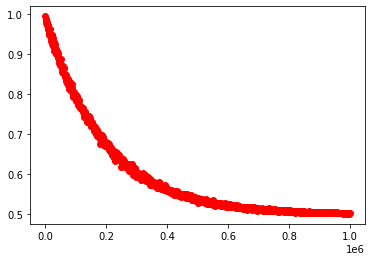

In [59]:
plt.plot(delay,success1,'ro--')
plt.show()

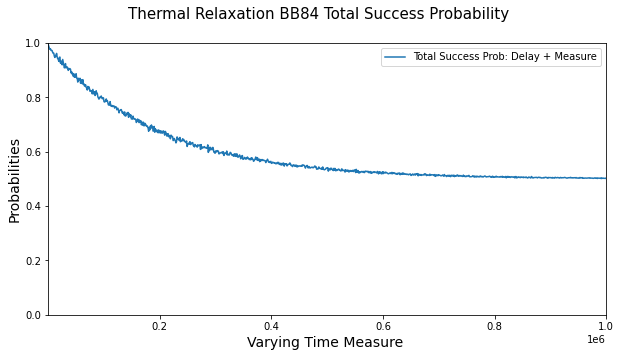

<Figure size 576x360 with 0 Axes>

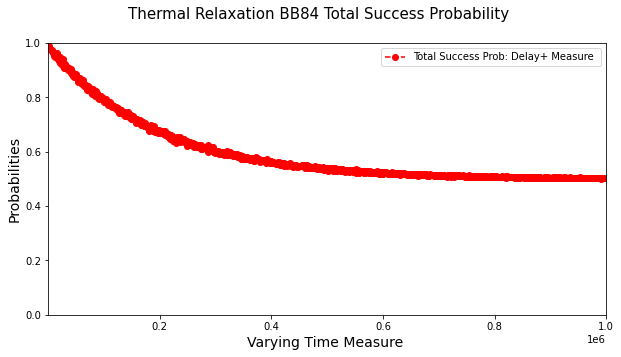

<Figure size 576x360 with 0 Axes>

In [58]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation BB84 Total Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success1,label = "Total Success Prob: Delay + Measure")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation BB84 Total Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success1,'ro--',label = "Total Success Prob: Delay+ Measure ")
ax.legend()

# Delay + Measure + Gate

In [47]:
import matplotlib.pyplot as plt
state_list=['1','2','3','4']
totalplist=[]
for i in range(len(state_list)):
    delay = np.arange(0,1001000,1000)
    channel = state_list[i]
    apply_error = {"delay":True, "measure": True, "gate": True}
    success = []

    # need to run in multiple loops to get a smoother curve
    for d in range(len(delay)):
        prob = run(channel,int(delay[d]),apply_error)
        success.append(prob)
    totalplist.append(success)

In [48]:
from statistics import mean
a= totalplist
print(*map(mean, zip(*a)))

0.99 0.9824999999999999 0.98175 0.98725 0.978 0.96475 0.97275 0.96825 0.96675 0.9655 0.964 0.9605 0.94775 0.9450000000000001 0.96225 0.948 0.9452499999999999 0.9377500000000001 0.9412499999999999 0.94925 0.93675 0.93725 0.93425 0.93775 0.9325 0.932 0.92625 0.9215 0.9219999999999999 0.933 0.92625 0.9155 0.90725 0.90875 0.91025 0.90175 0.8905000000000001 0.90525 0.8995 0.907 0.88625 0.89425 0.888 0.88675 0.8835 0.88775 0.89075 0.88225 0.874 0.87025 0.87825 0.8755 0.871 0.86475 0.87525 0.876 0.8634999999999999 0.8534999999999999 0.86625 0.858 0.8545 0.848 0.844 0.866 0.85275 0.84775 0.8435 0.84125 0.8485 0.8345 0.82325 0.845 0.8262499999999999 0.825 0.8180000000000001 0.8362499999999999 0.8255 0.82375 0.8285 0.82125 0.81725 0.812 0.8282499999999999 0.817 0.81475 0.81725 0.8142499999999999 0.81125 0.805 0.815 0.81175 0.80875 0.797 0.7967500000000001 0.79725 0.7975 0.7965 0.789 0.7935 0.78725 0.78625 0.7887500000000001 0.7847500000000001 0.788 0.77675 0.78625 0.777 0.7765 0.7765 0.7765 0.79

In [54]:
success2=[0.99,0.9824999999999999,0.98175,0.98725,0.978,0.96475,0.97275,0.96825,0.96675,0.9655,0.964,0.9605,0.94775,0.9450000000000001,0.96225,0.948,0.9452499999999999,0.9377500000000001,0.9412499999999999,0.94925,0.93675,0.93725,0.93425,0.93775,0.9325,0.932,0.92625,0.9215,0.9219999999999999,0.933,0.92625,0.9155,0.90725,0.90875,0.91025,0.90175,0.8905000000000001,0.90525,0.8995,0.907,0.88625,0.89425,0.888,0.88675,0.8835,0.88775,0.89075,0.88225,0.874,0.87025,0.87825,0.8755,0.871,0.86475,0.87525,0.876,0.8634999999999999,0.8534999999999999,0.86625,0.858,0.8545,0.848,0.844,0.866,0.85275,0.84775,0.8435,0.84125,0.8485,0.8345,0.82325,0.845,0.8262499999999999,0.825,0.8180000000000001,0.8362499999999999,0.8255,0.82375,0.8285,0.82125,0.81725,0.812,0.8282499999999999,0.817,0.81475,0.81725,0.8142499999999999,0.81125,0.805,0.815,0.81175,0.80875,0.797,0.7967500000000001,0.79725,0.7975,0.7965,0.789,0.7935,0.78725,0.78625,0.7887500000000001,0.7847500000000001,0.788,0.77675,0.78625,0.777,0.7765,0.7765,0.7765,0.79125,0.778,0.77375,0.776,0.766,0.75975,0.7715000000000001,0.76525,0.74525,0.76275,0.769,0.75375,0.76425,0.7505,0.76,0.75475,0.743,0.7484999999999999,0.7435,0.75225,0.7515000000000001,0.7384999999999999,0.741,0.7464999999999999,0.74675,0.749,0.743,0.7305,0.7365,0.73475,0.73,0.728,0.7315,0.7415,0.7404999999999999,0.7225,0.72125,0.723,0.729,0.718,0.7185,0.726,0.71975,0.71375,0.70825,0.722,0.716,0.722,0.717,0.711,0.70925,0.7075,0.7085,0.70675,0.706,0.7052499999999999,0.7045,0.699,0.7135,0.70125,0.6972499999999999,0.71175,0.70775,0.7,0.69275,0.696,0.69475,0.6995,0.6875,0.6852499999999999,0.6975,0.6925,0.6835,0.695,0.68,0.677,0.7005,0.69025,0.687,0.687,0.6875,0.674,0.6765,0.66625,0.677,0.67475,0.67625,0.6697500000000001,0.67225,0.6785,0.6687500000000001,0.67225,0.67675,0.6717500000000001,0.6745,0.66425,0.677,0.65825,0.67225,0.661,0.6607500000000001,0.6617500000000001,0.6687500000000001,0.66625,0.6607500000000001,0.6535,0.646,0.66025,0.6565,0.6505,0.653,0.64925,0.6555,0.65925,0.64425,0.658,0.655,0.644,0.65575,0.6355,0.6525,0.64775,0.64625,0.648,0.642,0.648,0.64775,0.6515,0.641,0.6355,0.64425,0.645,0.64175,0.648,0.63875,0.636,0.6405,0.63725,0.636,0.62425,0.6185,0.63725,0.6335,0.62925,0.6335,0.62775,0.6285000000000001,0.62525,0.633,0.626,0.63,0.62375,0.62525,0.6234999999999999,0.63125,0.623,0.61625,0.627,0.61325,0.61875,0.612,0.62425,0.621,0.62075,0.61375,0.614,0.62325,0.61975,0.6095,0.62325,0.60975,0.62225,0.613,0.61625,0.608,0.613,0.60825,0.6115,0.613,0.61925,0.62125,0.6,0.61025,0.603,0.608,0.61225,0.61175,0.59975,0.60575,0.5965,0.603,0.59725,0.5965,0.6075,0.606,0.60025,0.59625,0.59925,0.59725,0.6,0.602,0.6015,0.596,0.599,0.6005,0.5895,0.59625,0.597,0.59425,0.592,0.5935,0.5892499999999999,0.5945,0.5895,0.59525,0.5955,0.5895,0.59825,0.581,0.588,0.58275,0.585,0.5865,0.5832499999999999,0.59075,0.5885,0.5825,0.5745,0.57875,0.5835,0.5795,0.5772499999999999,0.5875,0.5835,0.57675,0.5885,0.586,0.5842499999999999,0.57475,0.58675,0.578,0.58075,0.58,0.57125,0.57275,0.574,0.5745,0.57275,0.57475,0.5752499999999999,0.5762499999999999,0.5702499999999999,0.5712499999999999,0.578,0.57775,0.57175,0.5715,0.5695,0.57375,0.56725,0.57075,0.57,0.578,0.5660000000000001,0.5725,0.5715,0.5705,0.566,0.5685,0.55875,0.57,0.565,0.56475,0.569,0.568,0.56475,0.5635,0.5665,0.56775,0.56775,0.5640000000000001,0.565,0.5615,0.56325,0.56175,0.55725,0.55975,0.5595,0.56575,0.56225,0.5605,0.568,0.5665,0.555,0.556,0.5587500000000001,0.5655,0.5607500000000001,0.5525,0.558,0.5585,0.5635,0.5615,0.55825,0.555,0.5485,0.5547500000000001,0.5575,0.5537500000000001,0.5577500000000001,0.55725,0.55975,0.5557500000000001,0.55325,0.5517500000000001,0.5589999999999999,0.553,0.5525,0.554,0.5505,0.5575,0.559,0.556,0.5525,0.5527500000000001,0.55125,0.54625,0.5507500000000001,0.54925,0.5517500000000001,0.5507500000000001,0.5535,0.5495,0.5537500000000001,0.5455,0.5465,0.54325,0.5465,0.5465,0.551,0.5475,0.5495,0.5485,0.54825,0.54425,0.5505,0.54325,0.5417500000000001,0.54425,0.5467500000000001,0.547,0.5497500000000001,0.5445,0.546,0.542,0.5487500000000001,0.545,0.5447500000000001,0.5407500000000001,0.543,0.544,0.5445,0.54525,0.54525,0.54625,0.54225,0.54525,0.5395,0.544,0.5405,0.5445,0.53325,0.54025,0.5387500000000001,0.537,0.539,0.54125,0.5377500000000001,0.53825,0.546,0.53725,0.5397500000000001,0.5415,0.5375,0.53925,0.5357500000000001,0.5387500000000001,0.5377500000000001,0.53725,0.53825,0.538,0.53825,0.5367500000000001,0.5385,0.539,0.5347500000000001,0.5375,0.5345,0.53625,0.5397500000000001,0.53525,0.5327500000000001,0.5305,0.5327500000000001,0.5317500000000001,0.53225,0.5357500000000001,0.5347500000000001,0.5315,0.5305,0.52925,0.5337500000000001,0.5367500000000001,0.5345,0.531,0.5325,0.53025,0.528,0.532,0.53325,0.5285,0.53325,0.52925,0.534,0.53025,0.529,0.524,0.53,0.52975,0.5265,0.52525,0.53025,0.5337500000000001,0.5265,0.527,0.526,0.5327500000000001,0.53025,0.5325,0.5315,0.5335,0.5255,0.52475,0.52925,0.5225,0.52675,0.5285,0.5335,0.5275,0.5275,0.52775,0.5265,0.5315,0.52625,0.528,0.52625,0.52325,0.52625,0.523,0.528,0.52375,0.522,0.524,0.52575,0.53025,0.53,0.525,0.527,0.5265,0.52425,0.52375,0.523,0.5225,0.52525,0.5205,0.52125,0.522,0.52775,0.52325,0.52675,0.5225,0.5235,0.52,0.52475,0.5225,0.52125,0.51975,0.5225,0.51775,0.52525,0.52475,0.51925,0.52325,0.5155,0.522,0.5225,0.5175,0.5245,0.527,0.52125,0.5215,0.5185,0.5205,0.5175,0.52025,0.519,0.521,0.52,0.524,0.52325,0.52125,0.515,0.52,0.5165,0.52075,0.516,0.51975,0.5195,0.5225,0.519,0.5205,0.513,0.515,0.51425,0.5185,0.51675,0.522,0.51675,0.51525,0.51725,0.52275,0.51725,0.51825,0.5175,0.516,0.519,0.512,0.51625,0.519,0.516,0.5175,0.51775,0.51875,0.5165,0.516,0.51425,0.51425,0.5195,0.5155,0.5145,0.515,0.518,0.51725,0.51525,0.5155,0.51525,0.51625,0.51725,0.51475,0.51525,0.511,0.513,0.5145,0.51825,0.51225,0.5115,0.513,0.51725,0.5135,0.51275,0.519,0.5145,0.51475,0.51575,0.5115,0.51325,0.51575,0.5125,0.51675,0.51575,0.513,0.51575,0.515,0.515,0.515,0.5175,0.51575,0.51375,0.51225,0.51425,0.5105,0.51525,0.51325,0.51225,0.51125,0.51075,0.51175,0.5115,0.50925,0.5145,0.51125,0.512,0.51575,0.512,0.51175,0.51125,0.5125,0.51225,0.5095,0.51225,0.51125,0.51125,0.50925,0.50925,0.51125,0.51225,0.511,0.51075,0.5095,0.5085,0.51225,0.51475,0.5115,0.51275,0.51275,0.50975,0.51125,0.512,0.5095,0.50775,0.51325,0.51125,0.51175,0.51,0.51175,0.50925,0.5095,0.509,0.50925,0.51,0.5095,0.511,0.5085,0.51225,0.51175,0.509,0.511,0.5105,0.511,0.51075,0.5095,0.509,0.50925,0.5085,0.50825,0.50975,0.5085,0.508,0.51175,0.5095,0.51325,0.51275,0.51,0.51075,0.50975,0.50975,0.50875,0.50875,0.51,0.50775,0.50925,0.5105,0.5095,0.508,0.50825,0.507,0.507,0.50625,0.506,0.50925,0.5095,0.5095,0.5075,0.506,0.5075,0.5095,0.50975,0.50725,0.50675,0.51125,0.508,0.50775,0.5075,0.508,0.507,0.50875,0.50825,0.50825,0.5075,0.5055,0.50875,0.50575,0.507,0.50825,0.50875,0.507,0.50775,0.50825,0.50525,0.50575,0.50725,0.5075,0.50675,0.506,0.50625,0.50575,0.50625,0.5045,0.5065,0.50675,0.50775,0.5045,0.505,0.50725,0.5065,0.50725,0.50675,0.50725,0.5045,0.505,0.50525,0.50575,0.50575,0.50625,0.50775,0.5065,0.507,0.50675,0.5035,0.5055,0.508,0.5065,0.5045,0.50725,0.5075,0.5075,0.505,0.50625,0.50525,0.50325,0.506,0.50725,0.50475,0.5065,0.5075,0.5045,0.503,0.50525,0.5065,0.50475,0.5045,0.5065,0.50675,0.50625,0.5045,0.50675,0.5045,0.507,0.503,0.50575,0.50475,0.5055,0.505,0.50525,0.50475,0.50475,0.5065,0.50425,0.5055,0.5045,0.50575,0.50625,0.50575,0.50475,0.5035,0.50375,0.5045,0.50525,0.50525,0.506,0.50525,0.50525,0.505,0.5035,0.506,0.5045,0.5035,0.504,0.5045,0.50425,0.5035,0.504,0.505,0.50625,0.504,0.50375,0.5055,0.50375,0.504,0.505,0.5045,0.50375,0.5035,0.503,0.50375,0.5035,0.50375,0.5035,0.505,0.5055,0.503,0.50425,0.505,0.5035,0.506,0.50575,0.50475,0.50525,0.5025,0.5045,0.50375,0.5045,0.50325,0.5035,0.50475,0.50275,0.50525,0.5035,0.50325,0.5045,0.5045,0.503,0.50175,0.5055,0.50175,0.50375,0.50425,0.5025,0.5025,0.50275,0.505,0.503,0.5035,0.5035,0.50225,0.50475,0.50275,0.5015,0.505,0.5025,0.5045,0.50375,0.503,0.502,0.5035,0.503,0.5035,0.5025,0.50175,0.5015,0.50225,0.50225,0.505,0.50325,0.50175,0.503,0.5015,0.503,0.50275,0.5025,0.50175,0.50225,0.50325,0.50375,0.5035,0.504,0.50225,0.50175,0.50325,0.50275,0.50375]

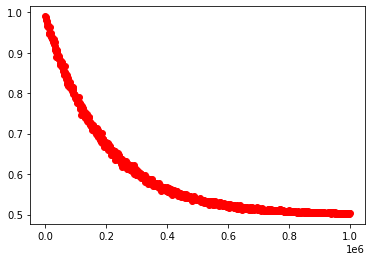

In [55]:
plt.plot(delay,success2,'ro--')
plt.show()

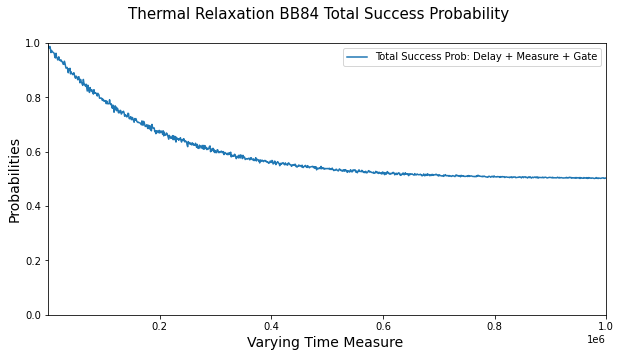

<Figure size 576x360 with 0 Axes>

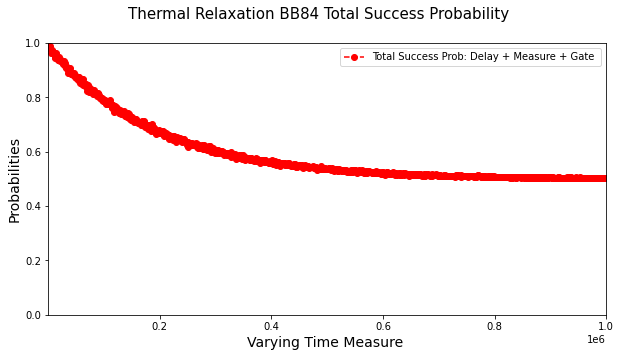

<Figure size 576x360 with 0 Axes>

In [56]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation BB84 Total Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success2,label = "Total Success Prob: Delay + Measure + Gate")
ax.legend()

#################################################################################

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation BB84 Total Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success2,'ro--',label = "Total Success Prob: Delay + Measure + Gate ")
ax.legend()

# All Graph Combine

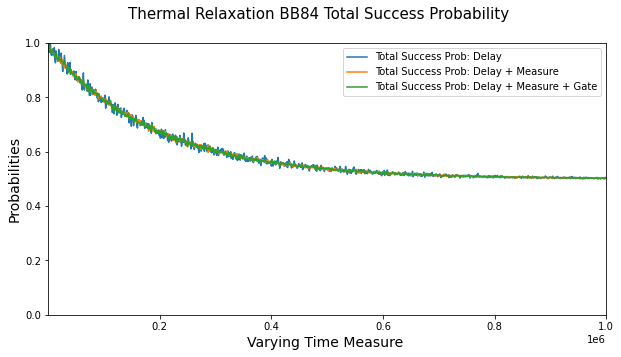

<Figure size 576x360 with 0 Axes>

In [57]:
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import matplotlib.pyplot as plt
from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
fig, ax = plt.subplots(figsize=(10, 5))
fig.suptitle('Thermal Relaxation BB84 Total Success Probability',fontsize=15)
ax.set_xlim(10, 1000000)
ax.set_ylim(0,1)
plt.ylabel('Probabilities',fontsize=14)
plt.xlabel('Varying Time Measure ',fontsize=14)
fig = plt.figure(figsize=(8,5))
ax.plot(delay,success,label = "Total Success Prob: Delay ")
ax.plot(delay,success1,label = "Total Success Prob: Delay + Measure ")
ax.plot(delay,success2,label = "Total Success Prob: Delay + Measure + Gate")
ax.legend()
